In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score


In [2]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [3]:
print("Shape of the DataFrame:", df.shape)
print("\nData types of each column:\n")
df.info()
print("\nMissing values in each column:\n", df.isnull().sum())

Shape of the DataFrame: (1470, 35)

Data types of each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement

In [4]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})


numerical_cols_for_outlier_removal = df.select_dtypes(include=np.number).columns.tolist()
if 'Attrition' in numerical_cols_for_outlier_removal:
    numerical_cols_for_outlier_removal.remove('Attrition')

df_cleaned = df.copy()
for col in numerical_cols_for_outlier_removal:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

print(f"Shape of the original DataFrame: {df.shape}")
print(f"Shape of the DataFrame after outlier removal: {df_cleaned.shape}")

Shape of the original DataFrame: (1470, 35)
Shape of the DataFrame after outlier removal: (699, 35)


**Reasoning**:
Apply Yeo-Johnson transformation to numerical columns in df_cleaned (excluding Attrition) and check skewness.



In [5]:
from sklearn.preprocessing import PowerTransformer

numerical_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()
if 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')

pt = PowerTransformer(method='yeo-johnson')
df_cleaned[numerical_cols] = pt.fit_transform(df_cleaned[numerical_cols])


numerical_cols_after_transform = df_cleaned.select_dtypes(include=np.number).columns
skewness_after_transform = df_cleaned[numerical_cols_after_transform].skew().sort_values(ascending=False)
print("\nSkewness of numerical columns after Yeo-Johnson transformation:")
print(skewness_after_transform)


Skewness of numerical columns after Yeo-Johnson transformation:
Attrition                   1.718609
YearsSinceLastPromotion     0.218151
StockOptionLevel            0.120561
JobLevel                    0.107657
PercentSalaryHike           0.060245
NumCompaniesWorked          0.012509
MonthlyIncome               0.008970
PerformanceRating           0.000000
StandardHours               0.000000
EmployeeCount               0.000000
Age                        -0.000544
TrainingTimesLastYear      -0.014637
WorkLifeBalance            -0.019841
JobInvolvement             -0.019856
DistanceFromHome           -0.020042
YearsInCurrentRole         -0.035059
YearsWithCurrManager       -0.038131
TotalWorkingYears          -0.038767
YearsAtCompany             -0.044757
HourlyRate                 -0.111362
Education                  -0.114889
MonthlyRate                -0.173696
RelationshipSatisfaction   -0.195549
EnvironmentSatisfaction    -0.199389
DailyRate                  -0.205785
JobSatisfa

**Reasoning**:
Identify categorical columns and apply Label Encoding to convert them into numerical representations.



In [6]:
categorical_cols = df_cleaned.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

display(df_cleaned.head())

Age  Attrition  BusinessTravel  DailyRate  Department  \
2   0.355014          1               2   1.353731           1   
3  -0.122037          0               1   1.394964           1   
5  -0.249602          0               1   0.528047           1   
11 -0.655531          0               2  -1.765925           1   
12 -0.380883          0               2  -0.282712           1   

    DistanceFromHome  Education  EducationField  EmployeeCount  \
2          -1.027780  -0.864869               4            0.0   
3          -0.710099   1.124146               1            0.0   
5          -1.027780  -0.864869               1            0.0   
11          0.892787  -0.864869               1            0.0   
12          1.530068  -1.718796               1            0.0   

    EmployeeNumber  ...  RelationshipSatisfaction  StandardHours  \
2        -2.159740  ...                 -0.701315            0.0   
3        -2.151949  ...                  0.223755            0.0   
5        -2.130659  ...                  0.223755            0.0   
11       -2.088097  ...                  1.229578            0.0   
12       -2.082544  ...                  1.229578            0.0   

    StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
2          -1.004096          -0.155755               0.652211   
3          -1.004096           0.055444               0.652211   
5          -1.004096           0.055444              -0.670724   
11         -1.004096           0.446441               0.652211   
12          0.755936          -0.620363              -2.134031   

    WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
2          0.283931       -2.102785           -1.553223   
3          0.283931        0.934158            1.231863   
5         -1.083154        0.714354            1.231863   
11         0.283931        1.137625            0.782867   
12        -1.083154        0.209733           -0.209558   

    YearsSinceLastPromotion  YearsWithCurrManager  
2                 -0.997565             -1.500181  
3                  1.458089             -1.500181  
5                  1.458089              1.058942  
11                -0.997565              1.452828  
12                 1.659428              0.237867  

[5 rows x 35 columns]

**Reasoning**:
Define the list of columns to drop and remove them from the DataFrame.



In [7]:

columns_to_drop = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']

existing_columns_to_drop = [col for col in df_cleaned.columns if col in columns_to_drop]
df_cleaned.drop(existing_columns_to_drop, axis=1, inplace=True)

display(df_cleaned.head())
print("Shape of the DataFrame after dropping columns:", df_cleaned.shape)

Age  Attrition  BusinessTravel  DailyRate  Department  \
2   0.355014          1               2   1.353731           1   
3  -0.122037          0               1   1.394964           1   
5  -0.249602          0               1   0.528047           1   
11 -0.655531          0               2  -1.765925           1   
12 -0.380883          0               2  -0.282712           1   

    DistanceFromHome  Education  EducationField  EnvironmentSatisfaction  \
2          -1.027780  -0.864869               4                 1.206340   
3          -0.710099   1.124146               1                 1.206340   
5          -1.027780  -0.864869               1                 1.206340   
11          0.892787  -0.864869               1                 1.206340   
12          1.530068  -1.718796               1                -1.520554   

    Gender  ...  PerformanceRating  RelationshipSatisfaction  \
2        1  ...                0.0                 -0.701315   
3        0  ...                0.0                  0.223755   
5        1  ...                0.0                  0.223755   
11       0  ...                0.0                  1.229578   
12       1  ...                0.0                  1.229578   

    StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
2          -1.004096          -0.155755               0.652211   
3          -1.004096           0.055444               0.652211   
5          -1.004096           0.055444              -0.670724   
11         -1.004096           0.446441               0.652211   
12          0.755936          -0.620363              -2.134031   

    WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
2          0.283931       -2.102785           -1.553223   
3          0.283931        0.934158            1.231863   
5         -1.083154        0.714354            1.231863   
11         0.283931        1.137625            0.782867   
12        -1.083154        0.209733           -0.209558   

    YearsSinceLastPromotion  YearsWithCurrManager  
2                 -0.997565             -1.500181  
3                  1.458089             -1.500181  
5                  1.458089              1.058942  
11                -0.997565              1.452828  
12                 1.659428              0.237867  

[5 rows x 31 columns]

Shape of the DataFrame after dropping columns: (699, 31)


**Reasoning**:
Define features and target variables and split the data into training and testing sets.



In [8]:
columns_to_exclude = ['Attrition']
X = df_cleaned.drop(columns=columns_to_exclude, errors='ignore')
y = df_cleaned['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

feature_names = X_train.columns

**Reasoning**:
Scale the features using StandardScaler based on the instructions.



In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train model




In [10]:
log_reg = LogisticRegression(solver='liblinear', max_iter=100000, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [11]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

print("Accuracy:", report['accuracy'])
print("\nOverall Precision:", report['macro avg']['precision'])
print("Overall Recall:", report['macro avg']['recall'])
print("Overall F1-score:", report['macro avg']['f1-score'])

Accuracy: 0.8357142857142857

Overall Precision: 0.7285714285714285
Overall Recall: 0.8017241379310345
Overall F1-score: 0.7530485466676893


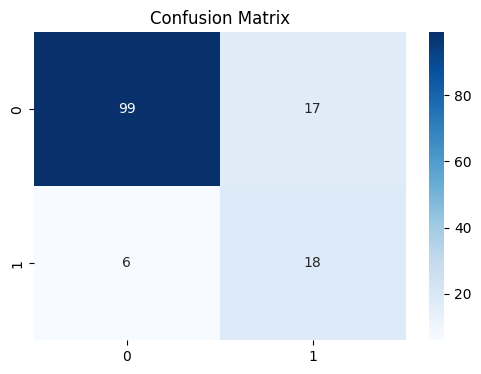

In [12]:

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


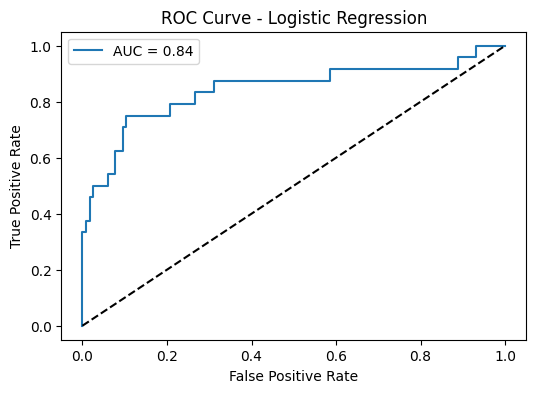

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In [14]:
# Feature Importance
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg.coef_[0]
})
importance['Abs_Coeff'] = abs(importance['Coefficient'])
importance = importance.sort_values(by='Abs_Coeff', ascending=False)
print("\nTop 10 Most Important Features:\n")
display(importance.head(10))


Top 10 Most Important Features:



Feature  Coefficient  Abs_Coeff
18                  OverTime     0.703455   0.703455
22          StockOptionLevel    -0.677808   0.677808
3                 Department     0.597361   0.597361
13           JobSatisfaction    -0.505217   0.505217
29      YearsWithCurrManager    -0.469692   0.469692
26            YearsAtCompany     0.468718   0.468718
23         TotalWorkingYears    -0.455625   0.455625
7    EnvironmentSatisfaction    -0.419795   0.419795
21  RelationshipSatisfaction    -0.398455   0.398455
15             MonthlyIncome    -0.395583   0.395583

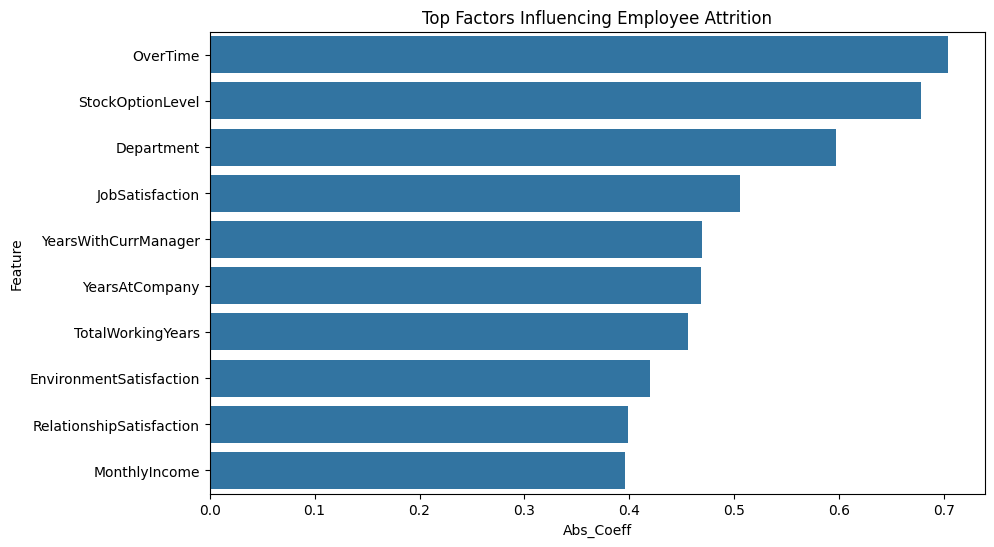

In [15]:
# Bar plot of top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coeff', y='Feature', data=importance.head(10))
plt.title("Top Factors Influencing Employee Attrition")
plt.show()

In [16]:

import pickle


with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)